# Road segmentation

In [20]:
%matplotlib inline

import numpy as np
import os,sys

from sklearn import preprocessing
from sklearn.metrics import f1_score

import tensorflow as tf
from tensorflow import keras

from helpers import *
from plots import *
import postprocessing
import models

from skimage.filters import gaussian

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Parameters

In [21]:
# Number of training images
n = 100

# Fix randomness (integer) or not (None)
seed = 0
tf.random.set_seed(seed)

# AIcrowd expects patches of 16 by 16 pixels.
patch_size = 16
aggregate_threshold = 0.3

nn_threshold = 0.3

# Percentage of pixels > 1 required to assign a foreground label to a patch (default=0.25)
foreground_threshold = 0.25

# Extraction function
#extraction_func = extract_features_2d
extraction_func = extract_features_6d
#extraction_func = extract_features_12d

# Preprocessing function
#preproc = None
preproc = preprocessing.StandardScaler()
#preproc = preprocessing.Normalizer()

image_proc = True

## Data extraction

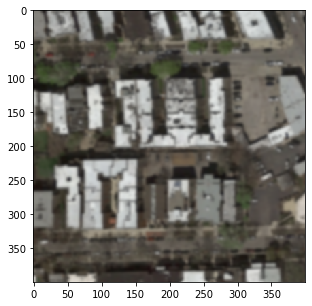

In [22]:
# Load a set of images
imgs, gt_imgs = load_training_images(n)
# Apply gaussian blur
for i in range(len(imgs)) :
    imgs[i] = gaussian(imgs[i], sigma = 2, multichannel = True)
    
show_img(imgs[0])

In [23]:
# Extract patches from all images
img_patches = get_patches(imgs, patch_size)
gt_patches = get_patches(gt_imgs, patch_size)

In [24]:
# Get features for each image patch
X = get_features_from_patches(img_patches, extraction_func)
Y = get_labels_from_patches(gt_patches, foreground_threshold)
print(X.shape)

(62500, 6)


In [25]:
# Preprocessing
if preproc is not None:
    preproc = preproc.fit(X)
    X = preproc.transform(X)
print(X)

[[ 1.166102    1.1697401   1.2226385  -0.13289829 -0.060279   -0.09160205]
 [ 1.4455236   1.4568464   1.5072889  -0.6591458  -0.59729916 -0.5631403 ]
 [ 0.791376    0.7459046   0.776813    0.02300387  0.10278217  0.18176366]
 ...
 [ 0.10743096  0.04588533  0.07330035 -0.3065346  -0.28455055 -0.28656197]
 [ 0.07257542 -0.08201777  0.03057908 -0.65459806 -0.59302056 -0.5786726 ]
 [ 0.01881667 -0.01467825  0.03793174 -0.26844603 -0.24154088 -0.2412784 ]]


## Model

In [26]:
#model = models.knn(X, Y, seed)
model = models.neural_net(X, Y)

Train on 56250 samples, validate on 6250 samples
Epoch 1/20
56250/56250 [==============================] - 11s 191us/sample - loss: 0.1514 - accuracy: 0.7788 - val_loss: 0.1508 - val_accuracy: 0.7640
Epoch 2/20
56250/56250 [==============================] - 8s 141us/sample - loss: 0.1433 - accuracy: 0.7903 - val_loss: 0.1517 - val_accuracy: 0.7675
Epoch 3/20
56250/56250 [==============================] - 11s 187us/sample - loss: 0.1421 - accuracy: 0.7921 - val_loss: 0.1471 - val_accuracy: 0.7851
Epoch 4/20
56250/56250 [==============================] - 11s 188us/sample - loss: 0.1410 - accuracy: 0.7936 - val_loss: 0.1491 - val_accuracy: 0.7659
Epoch 5/20
56250/56250 [==============================] - 10s 184us/sample - loss: 0.1400 - accuracy: 0.7938 - val_loss: 0.1495 - val_accuracy: 0.7763
Epoch 6/20
56250/56250 [==============================] - 11s 188us/sample - loss: 0.1394 - accuracy: 0.7950 - val_loss: 0.1482 - val_accuracy: 0.7686
Epoch 7/20
56250/56250 [======================

## Predictions

In [27]:
# Predict on the training set
Z = model.predict(X)
Z = postprocessing.threshold_labels(Z, nn_threshold)
Z = np.array(Z)

TPR = true_positive_rate(Z, Y) 
TNR = true_negative_rate(Z, Y)
FPR = false_positive_rate(Z, Y)
FNR = false_negative_rate(Z, Y)
F1 = f_score(Z, Y, beta=1)
print('True positive rate = ' + str(TPR))
print('True negative rate = ' + str(TNR))
print('False positive rate = ' + str(FPR))
print('False negative rate = ' + str(FNR))
print('F1 score = ' + str(F1))

True positive rate = 0.192624
True negative rate = 0.575952
False positive rate = 0.164992
False negative rate = 0.066432
F1 score = 0.6247210834933319


In [ ]:
# Predict on test set and create submission
create_submission(model, extraction_func, patch_size, preproc, aggregate_threshold, image_proc)

## Comparison of groundtruth and prediction

In [ ]:
idx = 1
img = imgs[idx]
img = gaussian(img, sigma = 2, multichannel = True)
gt_img = gt_imgs[idx]

# Run predictions
Xi = get_features_from_img(img, extraction_func, patch_size)
Yi = get_labels_from_img(gt_img, foreground_threshold, patch_size)
if preproc is not None:
    Xi = preproc.transform(Xi)
Zi = model.predict(Xi)
Zi = postprocessing.threshold_labels(Zi, nn_threshold)

In [ ]:
w = img.shape[0]
h = img.shape[1]
label_img = label_to_img(w, h, patch_size, patch_size, Yi)
predicted_img = label_to_img(w, h, patch_size, patch_size, Zi)

In [ ]:
print("Groundtruth:")
show_img(gt_imgs[idx])

In [ ]:
print("Patched groundtruth:")
show_img(label_img)

In [ ]:
print("Predictions:")
show_img(predicted_img)

## Visualization of a single test image

In [ ]:
# Load a test image
img_idx = 34

img_path = "Datasets/test_set_images/test_{0}/test_{0}.png".format(img_idx)
img = load_image(img_path)
img = gaussian(img, sigma = 2, multichannel = True)

In [ ]:
# Run predictions
Xi = get_features_from_img(img, extraction_func, patch_size)
if preproc is not None:
    Xi = preproc.transform(Xi)
Zi = model.predict(Xi)
Zi = postprocessing.threshold_labels(Zi, nn_threshold)

In [ ]:
# Data visualization if 2D
if Xi.shape[1] == 2:
    show_data_points(Xi, Zi)

In [ ]:
# Display prediction as an image
w = img.shape[0]
h = img.shape[1]
predicted_img = label_to_img(w, h, patch_size, patch_size, Zi)

show_img_concatenated(img, predicted_img)

In [ ]:
# Post processing
Zi = postprocessing.road_filters(Zi)
processed_img = label_to_img(w, h, 16, 16, Zi)

show_img(processed_img)
show_img_overlay(img, processed_img)